In [27]:
import re
import datetime

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler

%matplotlib inline

plt.style.use("seaborn-v0_8")

In [28]:
%%bash
ls -lh ../data/raw

total 3.4M
-rw-r--r-- 1 root root  159 Jul 12 11:43 prompts_test.csv
-rw-r--r-- 1 root root  16K Jul 12 11:43 prompts_train.csv
-rw-r--r-- 1 root root  111 Jul 12 11:43 sample_submission.csv
-rw-r--r-- 1 root root  166 Jul 12 11:43 summaries_test.csv
-rw-r--r-- 1 root root 3.3M Jul 12 11:43 summaries_train.csv


In [29]:
prompts_train = pd.read_csv('../data/raw/prompts_train.csv')
prompts_test = pd.read_csv('../data/raw/prompts_test.csv')
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')
summaries_train = pd.read_csv('../data/raw/summaries_train.csv')
summaries_test = pd.read_csv('../data/raw/summaries_test.csv')

In [30]:
display(prompts_train.head())
display(prompts_train.info())

display(summaries_train.head())
display(summaries_train.info())

display(sample_submission.head())

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prompt_id        4 non-null      object
 1   prompt_question  4 non-null      object
 2   prompt_title     4 non-null      object
 3   prompt_text      4 non-null      object
dtypes: object(4)
memory usage: 256.0+ bytes


None

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  7165 non-null   object 
 1   prompt_id   7165 non-null   object 
 2   text        7165 non-null   object 
 3   content     7165 non-null   float64
 4   wording     7165 non-null   float64
dtypes: float64(2), object(3)
memory usage: 280.0+ KB


None

,student_id,content,wording
0,000000ffffff,0.0,0.0
1,111111eeeeee,0.0,0.0
2,222222cccccc,0.0,0.0
3,333333dddddd,0.0,0.0


In [31]:
prompts_train['prompt_id'].nunique(), prompts_test['prompt_id'].nunique()

(4, 2)

In [32]:
# NOTE: train と test の prompt_id は重複していない
len(set(prompts_train['prompt_id'].unique().tolist()) | set(prompts_test['prompt_id'].unique().tolist()))

6

In [33]:
summaries_train['student_id'].nunique(), summaries_test['student_id'].nunique()

(7165, 4)

In [34]:
# NOTE: train と test の student_id は重複していない
len(set(summaries_train['student_id'].unique().tolist()) | set(summaries_test['student_id'].unique().tolist()))

7169

いずれもidは重複していないので、cvはKFoldで分割する。

## Missing Values

<Axes: >

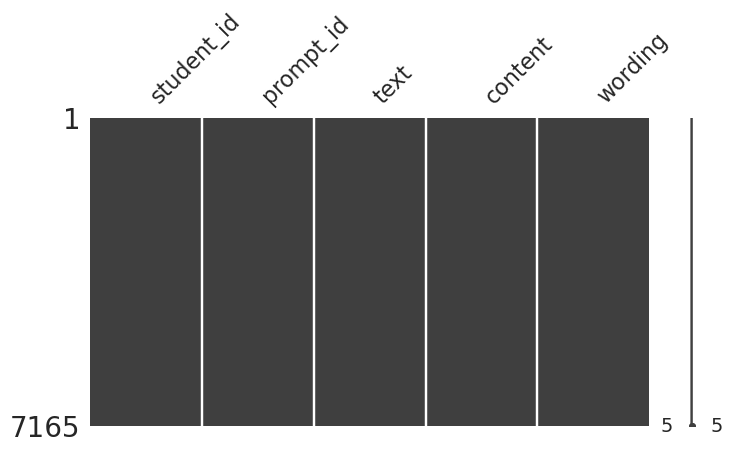

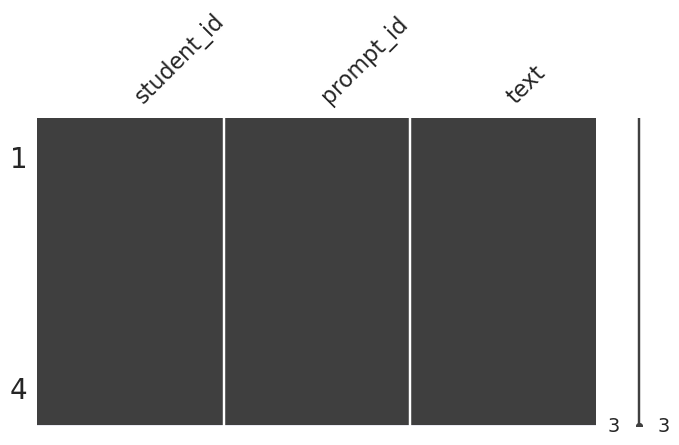

In [35]:
msno.matrix(summaries_train, figsize=(8, 4))
msno.matrix(summaries_test, figsize=(8, 4))

## Target Distribution

<Axes: >

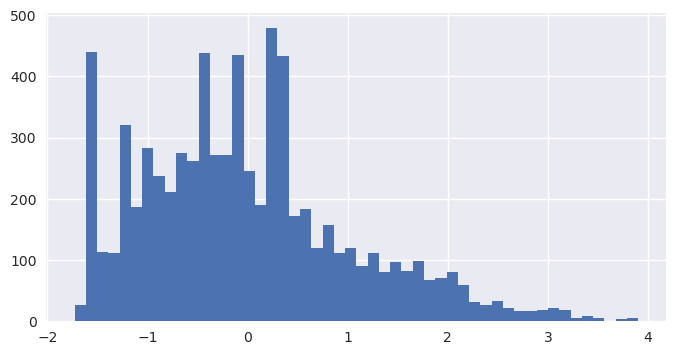

In [36]:
summaries_train["content"].hist(bins=50, figsize=(8, 4))

<Axes: >

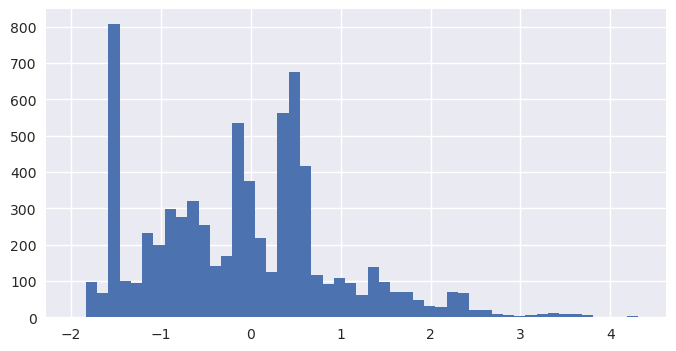

In [37]:
summaries_train["wording"].hist(bins=50, figsize=(8, 4))

<Axes: xlabel='content', ylabel='wording'>

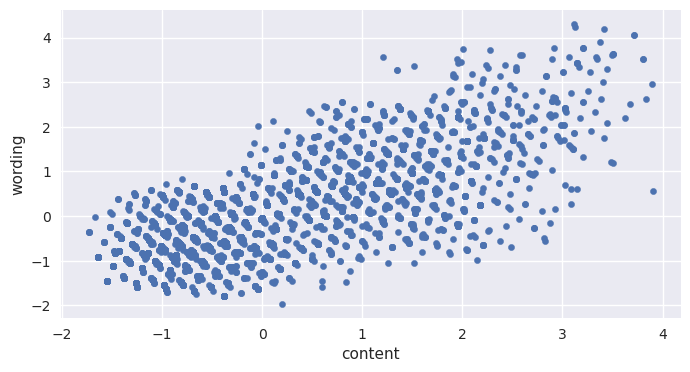

In [38]:
summaries_train.plot.scatter(x="content", y="wording", figsize=(8, 4))

## Text Features

In [56]:
summaries_train = summaries_train.assign(
    text_length=summaries_train["text"].str.len(),
    word_count=summaries_train["text"].str.split().str.len(),
    word_unique_count=summaries_train["text"].str.split().apply(set).str.len(),
    sentence_count=summaries_train["text"].str.split(".").str.len(),
    quoted_sentence_count=summaries_train["text"].apply(lambda x: len(re.findall(r'"(.*?)"', str(x)))),
    triple_dots_count=summaries_train["text"].apply(lambda x: len(re.findall(r"\.{3,4}", str(x)))),
)

In [57]:
def plot_feature(col: str = "text_length", bins: int = 50):
    summaries_train[col].hist(bins=50, figsize=(8, 4))
    summaries_train.plot.scatter(x="content", y=col, figsize=(8, 4))
    summaries_train.plot.scatter(x="wording", y=col, figsize=(8, 4))

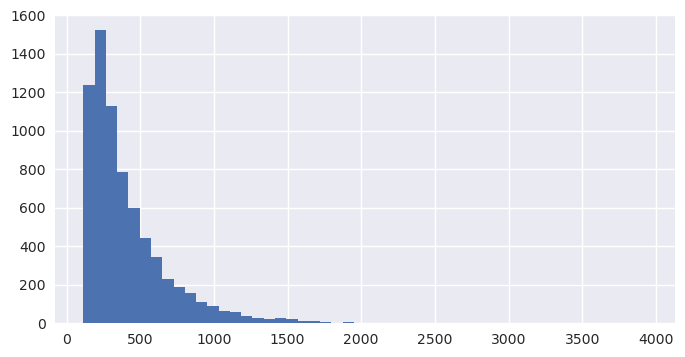

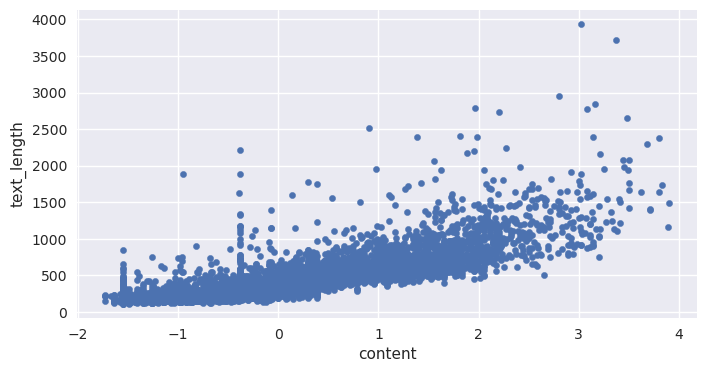

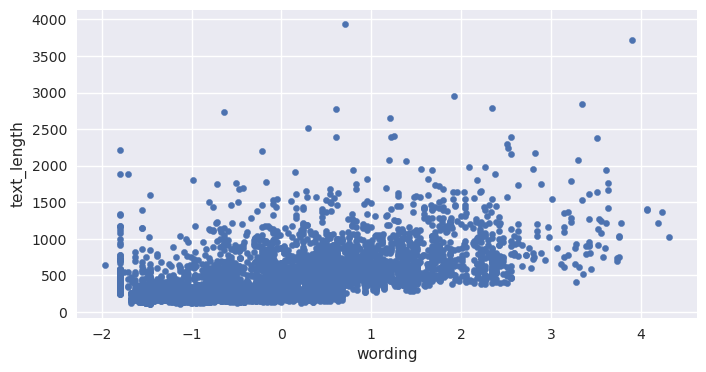

In [58]:
plot_feature("text_length")

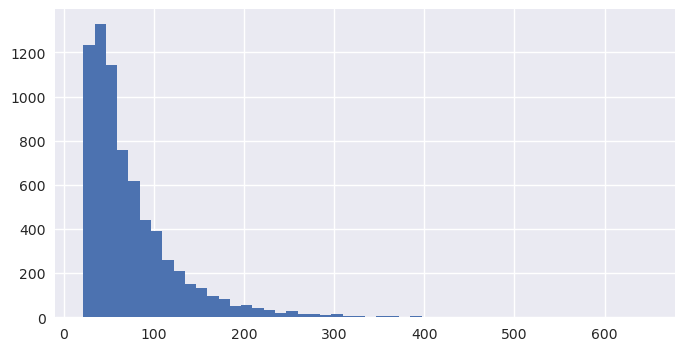

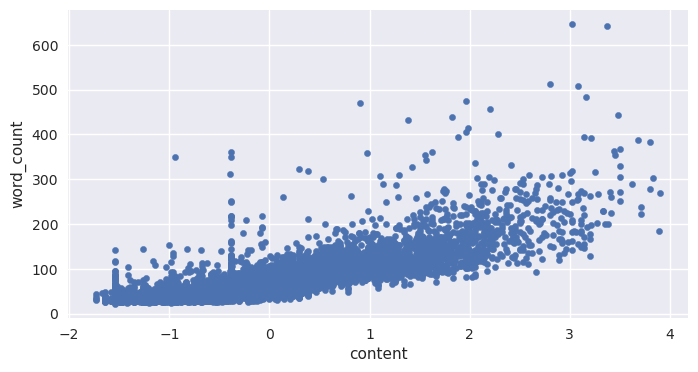

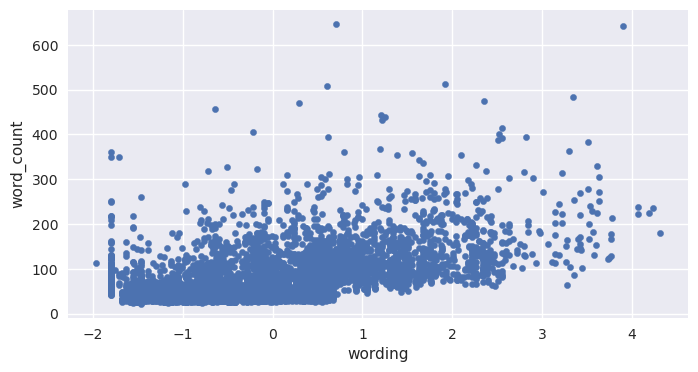

In [59]:
plot_feature("word_count")

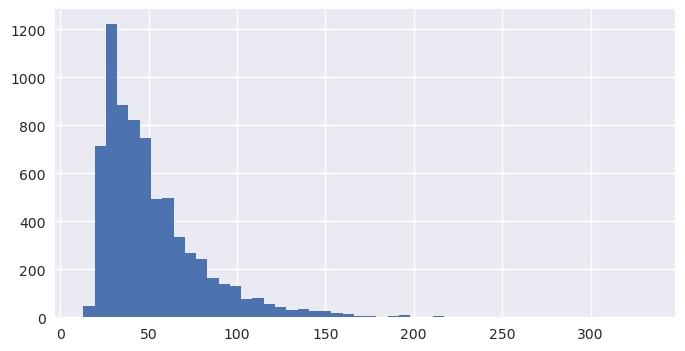

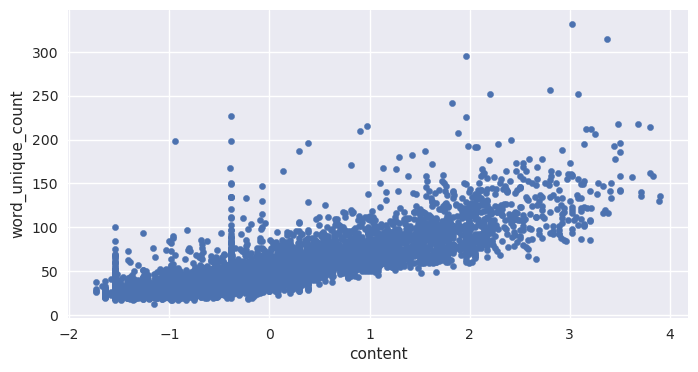

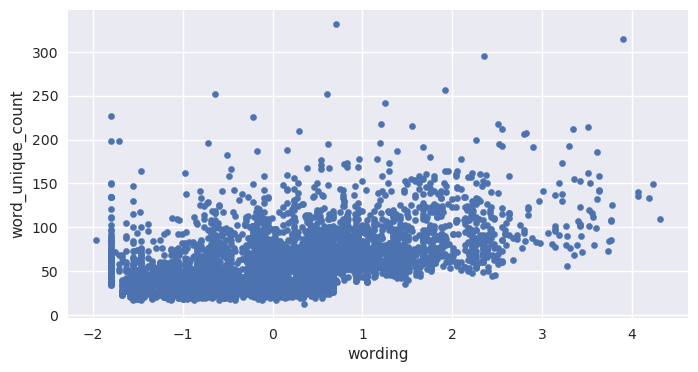

In [60]:
plot_feature("word_unique_count")

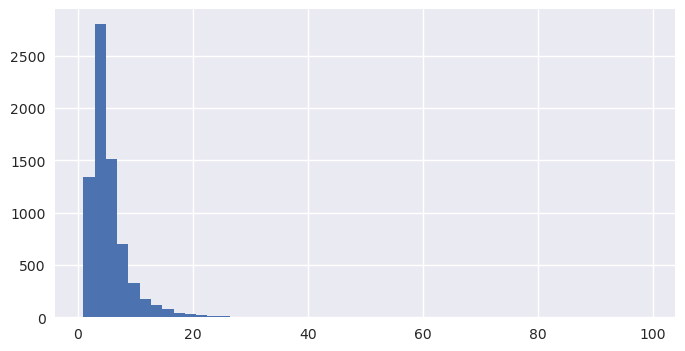

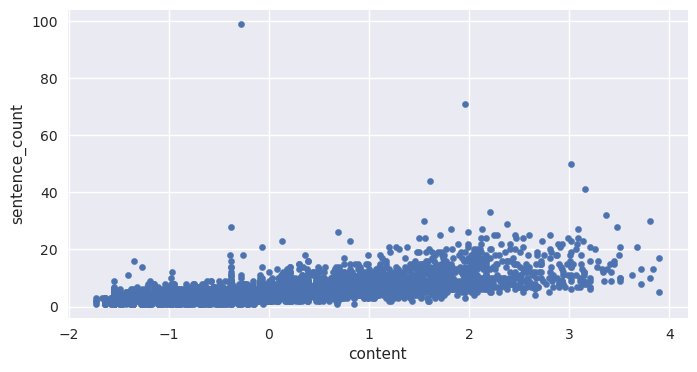

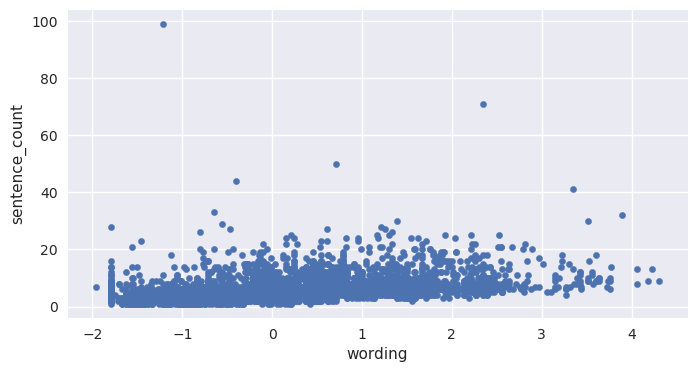

In [61]:
plot_feature("sentence_count")

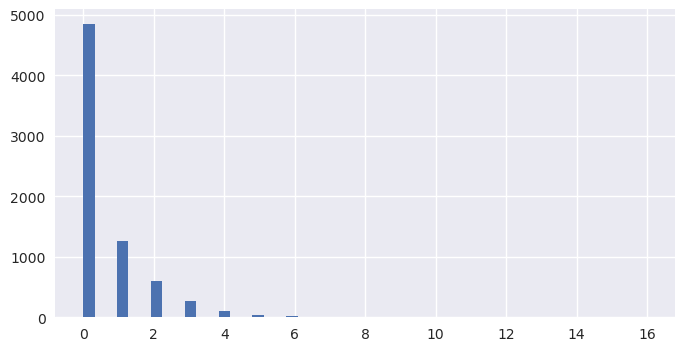

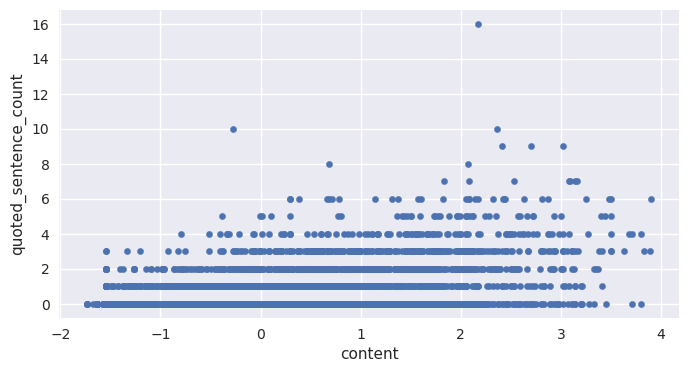

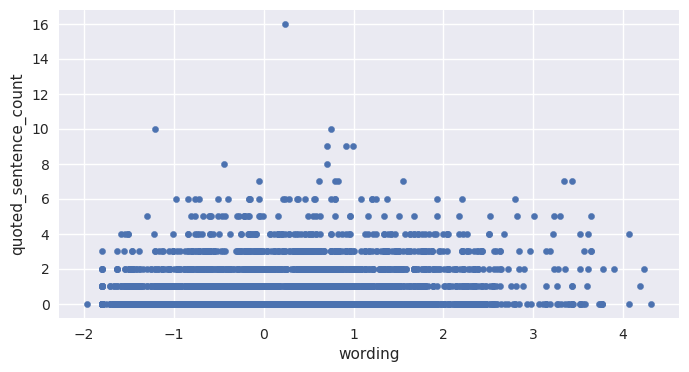

In [62]:
plot_feature("quoted_sentence_count")

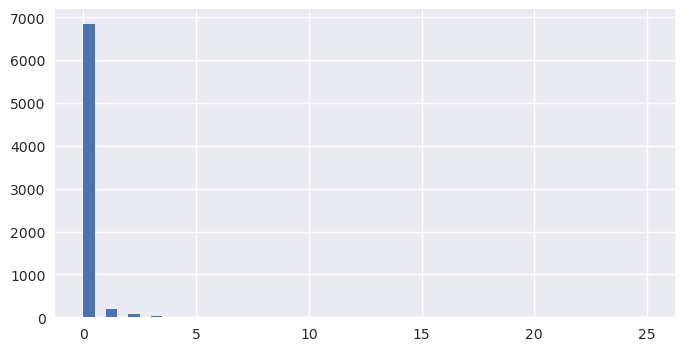

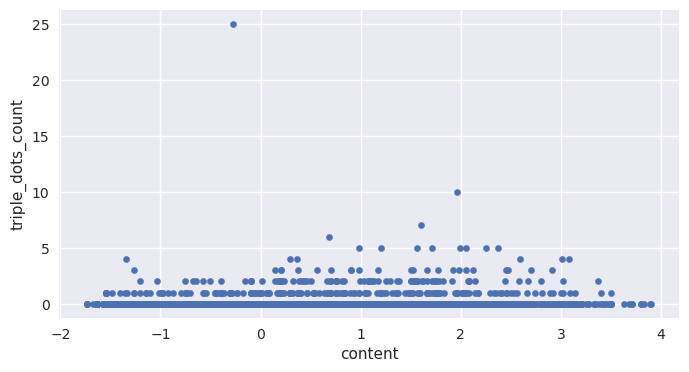

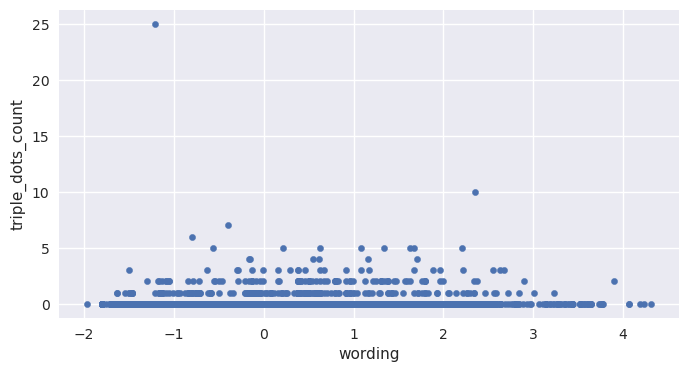

In [55]:
plot_feature("triple_dots_count")

textの前処理で気を付けたいやつ

- " で囲まれている文章の有無
  - 文章数のカウントで過増に読んでしまう

In [46]:
for row in summaries_train.sample(10).iterrows():
    print(row[1]["text"])
    print("-" * 100)

An ideal tragedy according to Aristotle means it has a good  plot, the change of fortune goes from good to bad not bad to go good. He also says the good story's are founded on a few houses on the fortunes of people. 
----------------------------------------------------------------------------------------------------
On the fourth day of the experiment, Jones decided to terminate the movement because it was slipping out of his control. The students became increasingly involved in the project and their discipline and loyalty to the project was outstanding. The main point of the experiment was to show that being peer pressured into following a crowd is bad. When they failed to follow the rules it was surpising, as seen here "Jones was surprised that some of the students started reporting to him when other members of the movement failed to abide by the rules." (3) It comes to show that it is very hard for some people to make their own choices/decisions.
------------------------------------